## 1. Paths & Training Hyperparameters

In [89]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"
MASK_ROOT = IMG_ROOT.replace("png_images", "png_masks")  

OUT_DIR   = "./ConvNeXt_V2_(Cls + Seg)output"

EPOCHS    = 200
BATCH     = 32
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"   

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./ConvNeXt_V2_(Cls + Seg)output
EPOCHS/BATCH/LR: 200 32 0.0002
VAL_RATIO/SAMPLER: 0.2 off


## 2. Imports & Device

In [90]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


## 3. Read CSVs & Quick Preview

In [91]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
5,5_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.11364.15178752...,0
6,6_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.4541.151787518...,0
7,7_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,1


,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
5,5_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5801.151787519...,0
6,6_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5802.151787519...,1
7,7_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,1


Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


## 4. Full-path Resolution & Dataset 

In [ ]:
def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y
    
class JointImageMaskTransform:
    def __init__(self, out_size=224):
        self.out_size = out_size

    def __call__(self, img, mask):
        # Adjust scales and perform joint transforms on img and mask
        img  = TF.resize(img,  (256, 256), interpolation=InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (256, 256), interpolation=InterpolationMode.NEAREST)

        # 2) Random resized crop
        i, j, h, w = torchvision.transforms.RandomResizedCrop.get_params(
            img, scale=(0.8, 1.0), ratio=(0.9, 1.1)
        )
        img  = TF.resized_crop(img,  i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.BILINEAR)
        mask = TF.resized_crop(mask, i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.NEAREST)

        # 3) Random horizontal flip
        if random.random() < 0.5:
            img  = TF.hflip(img)
            mask = TF.hflip(mask)

        # 4) To tensor and normalize
        img  = TF.to_tensor(img)               # [1,H,W], values in [0,1]
        img  = TF.normalize(img, [0.5], [0.25])

        mask = TF.to_tensor(mask)              # [1,H,W], values in [0,1]
        mask = (mask > 0.5).float()            # Clarify to binary mask

        return img, mask


class PandasImageMaskDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mask_root: str, joint_transform: JointImageMaskTransform):
        self.df = df.reset_index(drop=True)
        self.mask_root = mask_root
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Images come from full_path
        img_path = row["full_path"]
        img = Image.open(img_path).convert("L")

        # Masks come from mask_root + basename
        basename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_root, basename)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found for {img_path} -> {mask_path}")

        mask = Image.open(mask_path).convert("L")

        img, mask = self.joint_transform(img, mask)

        y = float(row["has_pneumo"])
        return img, y, mask

Missing files — Train: 0 | Test: 0


In [93]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df: pd.DataFrame, label_col: str, out_path: str, title: str):
    counts = df[label_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    xs = [str(int(x)) for x in counts.index.tolist()]
    ys = counts.values.astype(int)
    plt.bar(xs, ys)
    for i, y in enumerate(ys):
        plt.text(i, y, str(y), ha="center", va="bottom", fontsize=9)
    plt.title(f"Class Distribution — {title}")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

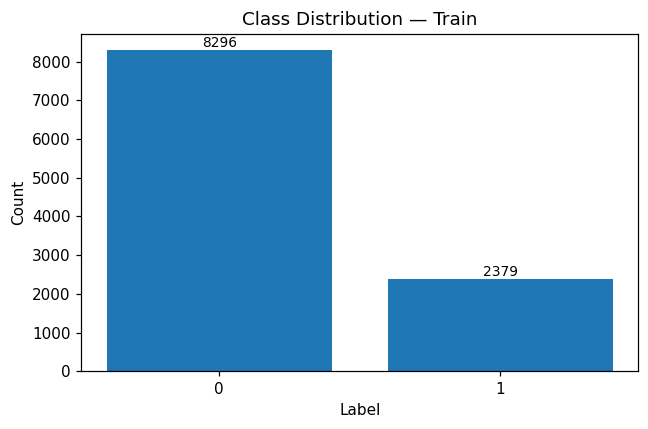

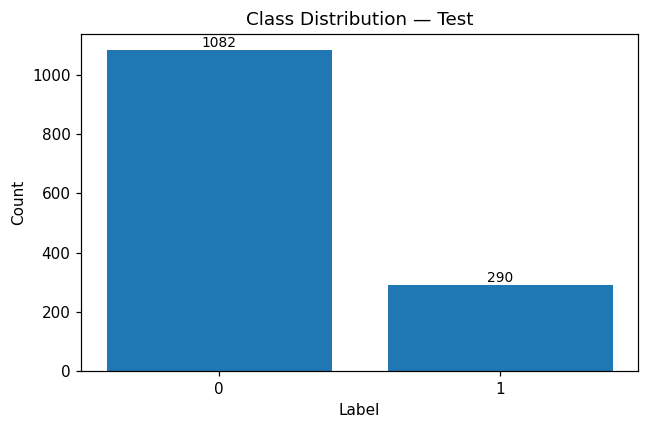

[Train] Missing: 0/10675 — saved to ./ConvNeXt_V2_(Cls + Seg)output\eda\missing_train.txt
[Test] Missing: 0/1372 — saved to ./ConvNeXt_V2_(Cls + Seg)output\eda\missing_test.txt


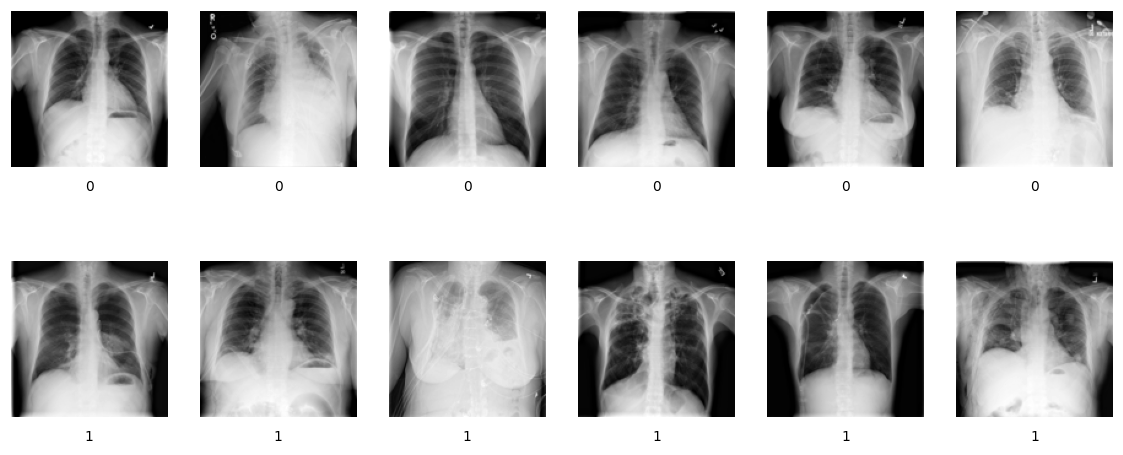

In [94]:
from pathlib import Path

eda_class_distribution(train_df, "has_pneumo", os.path.join(EDA_DIR, "class_dist_train.png"), "Train")
eda_class_distribution(test_df,  "has_pneumo", os.path.join(EDA_DIR, "class_dist_test.png"),  "Test")

eda_missing_files(train_df, os.path.join(EDA_DIR, "missing_train.txt"), "Train")
eda_missing_files(test_df,  os.path.join(EDA_DIR, "missing_test.txt"),  "Test")

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

eda_sample_grid(train_df, os.path.join(EDA_DIR, "sample_grid_train.png"), "Train", n_per_class=6, size=128)

In [ ]:
# Stratified split
tr_df, val_df = train_test_split(train_df, test_size=VAL_RATIO,
                                 stratify=train_df["has_pneumo"], random_state=SEED)
# Oversampling
pos_df = tr_df[tr_df["has_pneumo"] == 1]
neg_df = tr_df[tr_df["has_pneumo"] == 0]

target_pos = n_neg = len(neg_df)
n_pos = len(pos_df)

factor    = target_pos // n_pos
remainder = target_pos % n_pos

pos_oversampled = pd.concat(
    [pos_df] * factor + [pos_df.sample(remainder, replace=True, random_state=SEED)],
    ignore_index=True
)

tr_df_bal = pd.concat([neg_df, pos_oversampled], ignore_index=True)
tr_df_bal = tr_df_bal.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Distribution of Train after oversampling:",
      (tr_df_bal["has_pneumo"] == 1).sum(), "pos,",
      (tr_df_bal["has_pneumo"] == 0).sum(), "neg")

# Using oversampled training set
tr_df = tr_df_bal


过采样后 Train 分布: 6637 pos, 6637 neg


In [ ]:
# Transforms
train_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

joint_train_tfms = JointImageMaskTransform(out_size=224)

# Datasets
ds_train = PandasImageMaskDataset(tr_df, mask_root=MASK_ROOT, joint_transform=joint_train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)

if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

len(ds_train), len(ds_val), len(ds_test)

(13274, 2135, 1372)

In [ ]:
import os
import numpy as np
from PIL import Image

first_pos_idx = 1  

row = tr_df.iloc[first_pos_idx]
img_path = row["full_path"]
basename = os.path.basename(img_path)

print("img_path:", img_path)
print("basename:", basename)

print("MASK_ROOT:", MASK_ROOT)
mask_path = os.path.join(MASK_ROOT, basename)
print("mask_path:", mask_path, "exists:", os.path.exists(mask_path))

mask_raw = Image.open(mask_path).convert("L")
mask_np = np.array(mask_raw)

print("raw mask shape:", mask_np.shape)
print("raw mask min/max:", mask_np.min(), mask_np.max())
print("raw mask positive pixels (>0):", (mask_np > 0).sum())


img_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images\1602_train_1_.png
basename: 1602_train_1_.png
MASK_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks
mask_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks\1602_train_1_.png exists: True
raw mask shape: (1024, 1024)
raw mask min/max: 0 255
raw mask positive pixels (>0): 1576


In [ ]:
pos_indices = [i for i, v in enumerate(tr_df["has_pneumo"].values) if v == 1]
print("Positive sample number:", len(pos_indices))
first_pos_idx = pos_indices[0]

img, y, mask = ds_train[first_pos_idx]
print("index:", first_pos_idx)
print("label:", y)
print("mask shape:", mask.shape)
print("mask min/max:", mask.min().item(), mask.max().item())
print("mask positive pixels:", mask.sum().item())

正样本个数: 6637
index: 1
label: 1.0
mask shape: torch.Size([1, 224, 224])
mask min/max: 0.0 1.0
mask positive pixels: 87.0


# ConvNeXt_V2
## DropPath (Random Depth)

In [99]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # Only sample along batch dimension, broadcast others
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

## GRN

In [100]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

## LayerNorm2d

In [101]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

## ConvNeXt_V2 block

In [102]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  
    ):
        super().__init__()
        # 7x7 depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # Do LayerNorm in channels_last format
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## ConvNeXt_V2 tiny

In [ ]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0, 
    ):
        super().__init__()

        # 4 deepths and dims for each stage
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # Constructing the stem: patch embedding with stride=4
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # Constructing the blocks and downsampling layers for each stage
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # Every stage begins with a downsampling layer (except the first)
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # The last classification head: LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Global average pooling and normalization
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
    ):
        super().__init__()
        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,
        )

        # The last feature dimension from backbone
        last_dim = self.backbone.head.in_features

        # Header for classification: simple linear layer
        self.cls_head = nn.Linear(last_dim, n_classes)

        # Header for segmentation: conv layers
        self.seg_head = nn.Sequential(
            nn.Conv2d(last_dim, last_dim // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(last_dim // 2, 1, kernel_size=1),
        )

    def forward_backbone_spatial(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.backbone.downsample_layers[i](x)
            x = self.backbone.stages[i](x)
        return x

    def forward(self, x):
        # backbone spatial features
        feat = self.forward_backbone_spatial(x)  # [B,C,Hf,Wf]

        # Classification branch: GAP + cls head [B]
        gap = feat.mean(dim=[2, 3])             # [B,C]
        gap = self.backbone.norm_head(gap)
        cls_logits = self.cls_head(gap)         # [B,1]
        cls_logits = cls_logits.squeeze(1)      # [B]

        # Segmentation branch: conv head + upsample to input size [B,1,H,W]
        seg_logits = self.seg_head(feat)        # [B,1,Hf,Wf]
        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[-2:],                  # 224x224）
            mode="bilinear",
            align_corners=False,
        )

        return cls_logits, seg_logits


model = ConvNeXtV2TinyScratch(in_chans=1, n_classes=1, drop_path_rate=0.1).to(device)

In [ ]:
# Weights initialization
LAMBDA_SEG = 0.2

def dice_loss_with_logits(logits, targets, eps: float = 1e-6):
    """
    logits: [B,1,H,W]
    targets: [B,1,H,W] (0/1)
    """
    probs = torch.sigmoid(logits)

    # Flatten to [B, -1]
    probs_flat   = probs.view(probs.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    intersection = (probs_flat * targets_flat).sum(dim=1)
    union = probs_flat.sum(dim=1) + targets_flat.sum(dim=1)

    dice = (2 * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()

def dice_loss_with_logits_posonly(logits, targets, eps: float = 1e-6):
    probs = torch.sigmoid(logits)
    probs_flat   = probs.view(probs.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)

    # Positive pixels of each number
    target_sum = targets_flat.sum(dim=1)

    # Calculate dice loss only on positive pixels loss
    pos_mask = target_sum > 0
    if pos_mask.any():
        p_pos = probs_flat[pos_mask]
        t_pos = targets_flat[pos_mask]

        intersection = (p_pos * t_pos).sum(dim=1)
        union = p_pos.sum(dim=1) + t_pos.sum(dim=1)
        dice = (2 * intersection + eps) / (union + eps)
        return 1.0 - dice.mean()
    else:
        # No gradient if no positive pixels masks
        return logits.new_tensor(0.0)



In [105]:
# pos = (np.array(tr_df["has_pneumo"])==1).sum()
# neg = (np.array(tr_df["has_pneumo"])==0).sum()
# pos_weight = torch.tensor([neg / max(pos,1)], device=device, dtype=torch.float32)

# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

# print("pos/neg:", pos, neg, "| pos_weight:", pos_weight.item())

# Calculate class weights for Focal Loss
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

alpha = neg / (pos + neg + 1e-8)  

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# Define Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # Probabilities for the true class
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # Weighted alpha factor
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal weight
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # Basic BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Create criterion, optimizer, scheduler, scaler
criterion = BinaryFocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=6637, neg=6637, alpha=0.5000


C:\Users\Steven\AppData\Local\Temp\ipykernel_35800\123977394.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [106]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys, preds, scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        out = model(xb)
        if isinstance(out, tuple):
            logits, _ = out          # (cls_logits, seg_logits) → cls_logits
        else:
            logits = out

        probs = torch.sigmoid(logits)  # [B]
        pred = (probs >= 0.5).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(ys)
    y_pred = np.array(preds)
    y_score = np.array(scores)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity = TN / (TN + FP)
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    # ROC-AUC & PR-AUC
    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }
    return metrics, y_true, y_pred, y_score

def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

In [107]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.downsample_layers.0.0.weight
backbone.downsample_layers.0.0.bias
backbone.downsample_layers.0.1.weight
backbone.downsample_layers.0.1.bias
backbone.downsample_layers.1.0.weight
backbone.downsample_layers.1.0.bias
backbone.downsample_layers.1.1.weight
backbone.downsample_layers.1.1.bias
backbone.downsample_layers.2.0.weight
backbone.downsample_layers.2.0.bias
backbone.downsample_layers.2.1.weight
backbone.downsample_layers.2.1.bias
backbone.downsample_layers.3.0.weight
backbone.downsample_layers.3.0.bias
backbone.downsample_layers.3.1.weight
backbone.downsample_layers.3.1.bias
backbone.stages.0.0.dwconv.weight
backbone.stages.0.0.dwconv.bias
backbone.stages.0.0.norm.weight
backbone.stages.0.0.norm.bias
backbone.stages.0.0.pwconv1.weight
backbone.stages.0.0.pwconv1.bias
backbone.stages.0.0.grn.gamma
backbone.stages.0.0.grn.beta
backbone.stages.0.0.pwconv2.weight
backbone.stages.0.0.pwconv2.bias
backbone.stages.0.1.dwconv.weight
backbone.stages.0.1.dwconv.bias
backbone.stages.0.1

In [108]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running, running_cls, running_seg, nb = 0.0, 0.0, 0.0, 0 
    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb, mb in dl_train:   # clf + seg
        xb = xb.to(device, non_blocking=True)         # [B, 1, H, W]
        yb = yb.to(device, non_blocking=True).float() # [B]
        mb = mb.to(device, non_blocking=True).float() # [B, 1, H, W]

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            cls_logits, seg_logits = model(xb)   # ★ clds_logits: [B], seg_logits: [B,1,H,W]

            # Classification loss: Focal Loss
            cls_loss = criterion(cls_logits, yb)

            # Segmentation loss: BCE + Dice (only on positive samples)
            seg_loss_bce  = F.binary_cross_entropy_with_logits(seg_logits, mb)
            seg_loss_dice = dice_loss_with_logits_posonly(seg_logits, mb)
            seg_loss = seg_loss_bce + seg_loss_dice
            # seg_loss = dice_loss_with_logits(seg_logits, mb)

            # Total loss
            loss = cls_loss + LAMBDA_SEG * seg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Sum of three losses
        running      += loss.item()
        running_cls  += cls_loss.item()
        running_seg  += seg_loss.item()
        nb           += 1

        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]

        bar.set_postfix(
            loss=f"{running / max(nb, 1):.4f}",
            cls=f"{running_cls / max(nb, 1):.4f}",
            seg=f"{running_seg / max(nb, 1):.8f}",
            lr=f"{curr_lr:.2e}",
        )
        bar.update(1)

    scheduler.step()
    bar.close()

    # Calculate train and val loss for the epoch
    train_loss_epoch = running / max(nb, 1)

    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()

            with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
                out = model(xb)
                if isinstance(out, tuple):
                    logits, _ = out
                else:
                    logits = out
                loss_val = criterion(logits, yb)

            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# Save best model
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)

[Info] Start training...


Epoch 1/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 01/200 train_loss=0.3079 val_loss=0.1075 val_acc=0.2684 val_prec=0.2315 val_rec=0.9832 val_f1=0.3747 val_spec=0.0633 val_roc=0.6264 val_pr=0.3091 | val_pr_auc=0.3091 best_pr_auc=0.3091 (epoch 1)


Epoch 2/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 02/200 train_loss=0.2812 val_loss=0.0822 val_acc=0.6155 val_prec=0.3147 val_rec=0.6155 val_f1=0.4165 val_spec=0.6154 val_roc=0.6470 val_pr=0.3097 | val_pr_auc=0.3097 best_pr_auc=0.3097 (epoch 2)


Epoch 3/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 03/200 train_loss=0.2652 val_loss=0.0899 val_acc=0.5578 val_prec=0.3122 val_rec=0.8172 val_f1=0.4518 val_spec=0.4834 val_roc=0.7314 val_pr=0.4754 | val_pr_auc=0.4754 best_pr_auc=0.4754 (epoch 3)


Epoch 4/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 04/200 train_loss=0.2534 val_loss=0.0890 val_acc=0.5841 val_prec=0.3370 val_rec=0.8950 val_f1=0.4897 val_spec=0.4949 val_roc=0.7896 val_pr=0.5281 | val_pr_auc=0.5281 best_pr_auc=0.5281 (epoch 4)


Epoch 5/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 05/200 train_loss=0.2459 val_loss=0.0877 val_acc=0.6159 val_prec=0.3525 val_rec=0.8634 val_f1=0.5006 val_spec=0.5449 val_roc=0.7857 val_pr=0.5197 | val_pr_auc=0.5197 best_pr_auc=0.5281 (epoch 4)


Epoch 6/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 06/200 train_loss=0.2402 val_loss=0.0670 val_acc=0.7307 val_prec=0.4360 val_rec=0.7080 val_f1=0.5396 val_spec=0.7372 val_roc=0.8031 val_pr=0.5416 | val_pr_auc=0.5416 best_pr_auc=0.5416 (epoch 6)


Epoch 7/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 07/200 train_loss=0.2342 val_loss=0.0674 val_acc=0.7307 val_prec=0.4430 val_rec=0.8088 val_f1=0.5725 val_spec=0.7083 val_roc=0.8293 val_pr=0.5844 | val_pr_auc=0.5844 best_pr_auc=0.5844 (epoch 7)


Epoch 8/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 08/200 train_loss=0.2285 val_loss=0.0989 val_acc=0.5799 val_prec=0.3387 val_rec=0.9286 val_f1=0.4964 val_spec=0.4798 val_roc=0.8244 val_pr=0.5880 | val_pr_auc=0.5880 best_pr_auc=0.5880 (epoch 8)


Epoch 9/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 09/200 train_loss=0.2227 val_loss=0.0525 val_acc=0.8089 val_prec=0.5664 val_rec=0.6092 val_f1=0.5870 val_spec=0.8662 val_roc=0.8423 val_pr=0.6180 | val_pr_auc=0.6180 best_pr_auc=0.6180 (epoch 9)


Epoch 10/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 10/200 train_loss=0.2180 val_loss=0.0782 val_acc=0.6796 val_prec=0.4008 val_rec=0.8824 val_f1=0.5512 val_spec=0.6215 val_roc=0.8446 val_pr=0.6213 | val_pr_auc=0.6213 best_pr_auc=0.6213 (epoch 10)


Epoch 11/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 11/200 train_loss=0.2112 val_loss=0.0615 val_acc=0.7663 val_prec=0.4844 val_rec=0.7521 val_f1=0.5893 val_spec=0.7703 val_roc=0.8558 val_pr=0.6214 | val_pr_auc=0.6214 best_pr_auc=0.6214 (epoch 11)


Epoch 12/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 12/200 train_loss=0.2059 val_loss=0.0521 val_acc=0.8295 val_prec=0.6089 val_rec=0.6576 val_f1=0.6323 val_spec=0.8788 val_roc=0.8561 val_pr=0.6462 | val_pr_auc=0.6462 best_pr_auc=0.6462 (epoch 12)


Epoch 13/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 13/200 train_loss=0.2007 val_loss=0.0607 val_acc=0.8126 val_prec=0.5615 val_rec=0.7290 val_f1=0.6344 val_spec=0.8366 val_roc=0.8536 val_pr=0.6490 | val_pr_auc=0.6490 best_pr_auc=0.6490 (epoch 13)


Epoch 14/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 14/200 train_loss=0.1938 val_loss=0.0680 val_acc=0.7869 val_prec=0.5158 val_rec=0.7206 val_f1=0.6012 val_spec=0.8059 val_roc=0.8404 val_pr=0.6213 | val_pr_auc=0.6213 best_pr_auc=0.6490 (epoch 13)


Epoch 15/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 15/200 train_loss=0.1879 val_loss=0.0590 val_acc=0.8056 val_prec=0.5463 val_rec=0.7563 val_f1=0.6344 val_spec=0.8198 val_roc=0.8611 val_pr=0.6504 | val_pr_auc=0.6504 best_pr_auc=0.6504 (epoch 15)


Epoch 16/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 16/200 train_loss=0.1836 val_loss=0.0583 val_acc=0.8234 val_prec=0.5898 val_rec=0.6828 val_f1=0.6329 val_spec=0.8638 val_roc=0.8629 val_pr=0.6594 | val_pr_auc=0.6594 best_pr_auc=0.6594 (epoch 16)


Epoch 17/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 17/200 train_loss=0.1763 val_loss=0.0678 val_acc=0.7967 val_prec=0.5312 val_rec=0.7500 val_f1=0.6220 val_spec=0.8101 val_roc=0.8598 val_pr=0.6359 | val_pr_auc=0.6359 best_pr_auc=0.6594 (epoch 16)


Epoch 18/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 18/200 train_loss=0.1711 val_loss=0.0713 val_acc=0.8398 val_prec=0.6245 val_rec=0.7059 val_f1=0.6627 val_spec=0.8782 val_roc=0.8671 val_pr=0.6587 | val_pr_auc=0.6587 best_pr_auc=0.6594 (epoch 16)


Epoch 19/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 19/200 train_loss=0.1666 val_loss=0.0664 val_acc=0.8258 val_prec=0.5981 val_rec=0.6660 val_f1=0.6302 val_spec=0.8716 val_roc=0.8534 val_pr=0.6459 | val_pr_auc=0.6459 best_pr_auc=0.6594 (epoch 16)


Epoch 20/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 20/200 train_loss=0.1616 val_loss=0.0920 val_acc=0.8347 val_prec=0.6295 val_rec=0.6282 val_f1=0.6288 val_spec=0.8939 val_roc=0.8657 val_pr=0.6779 | val_pr_auc=0.6779 best_pr_auc=0.6779 (epoch 20)


Epoch 21/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 21/200 train_loss=0.1583 val_loss=0.0729 val_acc=0.8300 val_prec=0.6468 val_rec=0.5231 val_f1=0.5784 val_spec=0.9180 val_roc=0.8551 val_pr=0.6206 | val_pr_auc=0.6206 best_pr_auc=0.6779 (epoch 20)


Epoch 22/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 22/200 train_loss=0.1538 val_loss=0.0854 val_acc=0.8365 val_prec=0.6377 val_rec=0.6176 val_f1=0.6275 val_spec=0.8993 val_roc=0.8669 val_pr=0.6597 | val_pr_auc=0.6597 best_pr_auc=0.6779 (epoch 20)


Epoch 23/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 23/200 train_loss=0.1500 val_loss=0.0800 val_acc=0.8098 val_prec=0.5579 val_rec=0.7080 val_f1=0.6241 val_spec=0.8391 val_roc=0.8560 val_pr=0.6479 | val_pr_auc=0.6479 best_pr_auc=0.6779 (epoch 20)


Epoch 24/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 24/200 train_loss=0.1477 val_loss=0.0861 val_acc=0.8314 val_prec=0.6368 val_rec=0.5672 val_f1=0.6000 val_spec=0.9072 val_roc=0.8532 val_pr=0.6492 | val_pr_auc=0.6492 best_pr_auc=0.6779 (epoch 20)


Epoch 25/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 25/200 train_loss=0.1444 val_loss=0.1019 val_acc=0.8136 val_prec=0.5606 val_rec=0.7584 val_f1=0.6446 val_spec=0.8294 val_roc=0.8636 val_pr=0.6616 | val_pr_auc=0.6616 best_pr_auc=0.6779 (epoch 20)


Epoch 26/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 26/200 train_loss=0.1408 val_loss=0.1077 val_acc=0.8201 val_prec=0.5804 val_rec=0.6975 val_f1=0.6336 val_spec=0.8553 val_roc=0.8622 val_pr=0.6540 | val_pr_auc=0.6540 best_pr_auc=0.6779 (epoch 20)


Epoch 27/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 27/200 train_loss=0.1394 val_loss=0.1060 val_acc=0.8347 val_prec=0.6364 val_rec=0.6029 val_f1=0.6192 val_spec=0.9011 val_roc=0.8602 val_pr=0.6618 | val_pr_auc=0.6618 best_pr_auc=0.6779 (epoch 20)


Epoch 28/200:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 28/200 train_loss=0.1378 val_loss=0.1009 val_acc=0.8230 val_prec=0.6021 val_rec=0.6071 val_f1=0.6046 val_spec=0.8849 val_roc=0.8526 val_pr=0.6477 | val_pr_auc=0.6477 best_pr_auc=0.6779 (epoch 20)
[EarlyStop] Stop at epoch 28. Best pr_auc=0.6779 @ epoch 20.



[Best model @ Val]
Accuracy (%)        : 83.466
Precision (%)       : 62.947
Recall (%)          : 62.815
F1-Score (%)        : 62.881
Specificity (%)     : 89.391
ROC-AUC (%)         : 86.571
Precision-recall (%): 67.795

[Best model @ Test]
Accuracy (%)        : 83.09
Precision (%)       : 59.864
Recall (%)          : 60.69
F1-Score (%)        : 60.274
Specificity (%)     : 89.094
ROC-AUC (%)         : 86.093
Precision-recall (%): 65.598


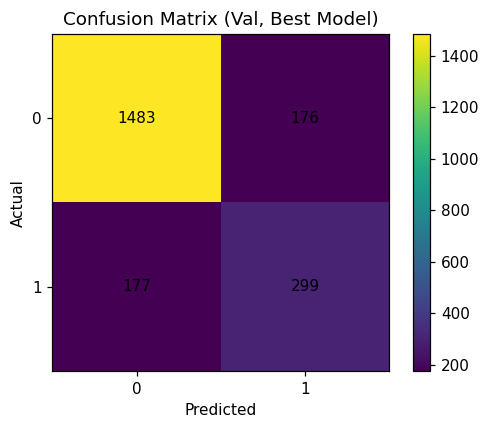

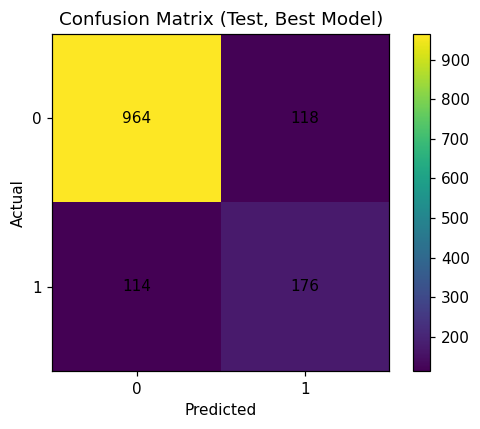

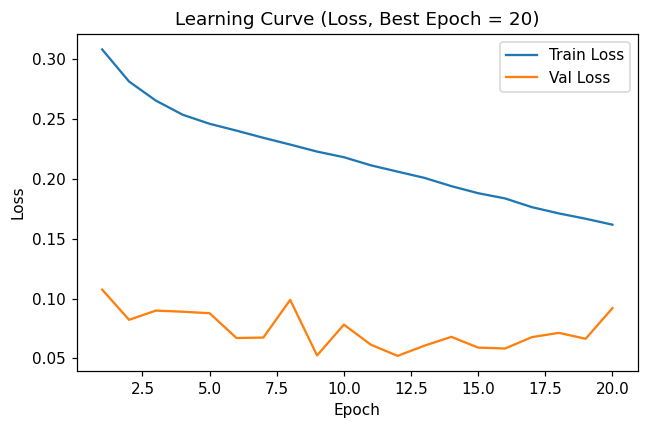

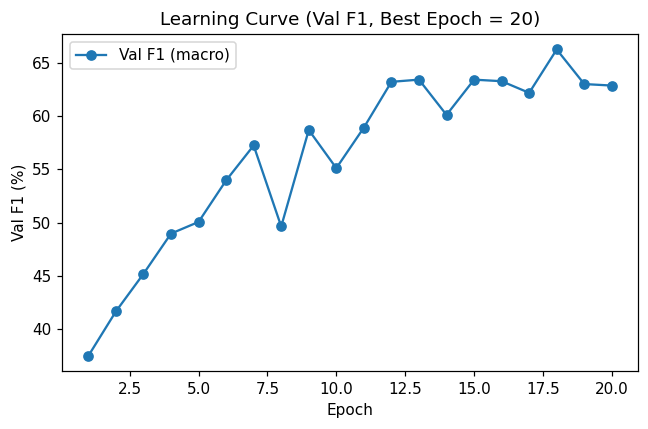

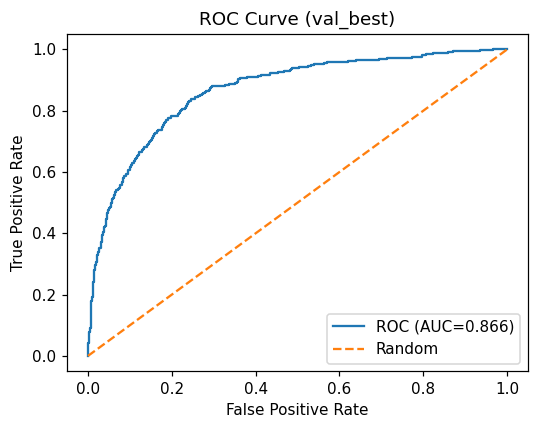

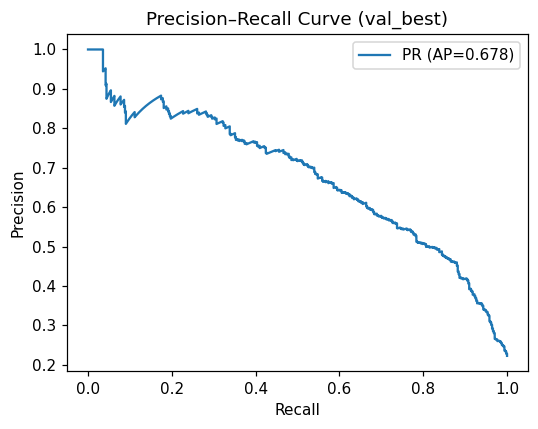

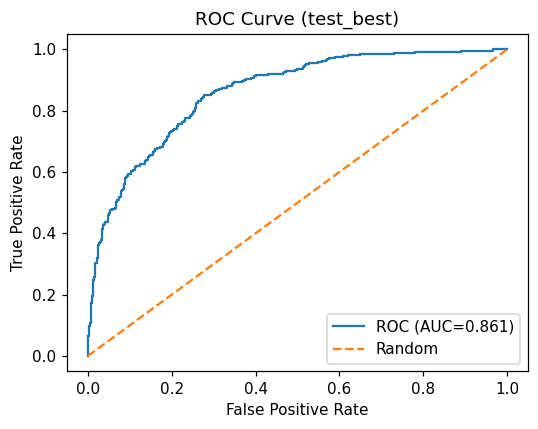

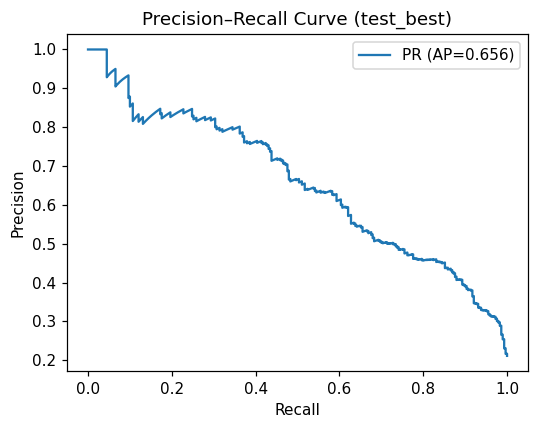

In [112]:
val_metrics_best, yv_best, pv_best, sv_best = evaluate(model, dl_val, device)
test_metrics_best, yt_best, pt_best, st_best = evaluate(model, dl_test, device)

val_pct = {k: round(v * 100, 3) for k, v in val_metrics_best.items()}
test_pct = {k: round(v * 100, 3) for k, v in test_metrics_best.items()}

print("\n[Best model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[Best model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])

plot_confusion_matrix(
    yv_best, pv_best,
    out_path=os.path.join(OUT_DIR, "confmat_val_best.png"),
    title="Confusion Matrix (Val, Best Model)"
)

plot_confusion_matrix(
    yt_best, pt_best,
    out_path=os.path.join(OUT_DIR, "confmat_test_best.png"),
    title="Confusion Matrix (Test, Best Model)"
)

plot_learning_curves(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal" 
)

plot_roc_pr(
    y_true=yv_best,
    y_score=sv_best,
    out_dir=OUT_DIR,
    prefix="val_best",
    roc_auc=val_metrics_best["roc_auc"],
    pr_auc=val_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yt_best,
    y_score=st_best,
    out_dir=OUT_DIR,
    prefix="test_best",
    roc_auc=test_metrics_best["roc_auc"],
    pr_auc=test_metrics_best["pr_auc"]
)

In [113]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(index=False, 
                                     formatters={"threshold": "{:.3f}".format,
                                                 "acc": "{:.3f}".format,
                                                 "prec": "{:.3f}".format,
                                                 "rec": "{:.3f}".format,
                                                 "f1": "{:.3f}".format,
                                                 "spec": "{:.3f}".format}))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted

df_thr_val = sweep_thresholds(yv_best, sv_best, sort_by="f1", verbose=True)

best_t = df_thr_val.iloc[0]["threshold"]
print(f"\n>>> The best threshold on validation set: best_t = {best_t:.3f}")

yt = np.asarray(yt_best).astype(int).ravel()
st = np.asarray(st_best).ravel()

y_test_pred = (st >= best_t).astype(int)

test_acc  = accuracy_score(yt, y_test_pred)
test_prec = precision_score(yt, y_test_pred, zero_division=0)
test_rec  = recall_score(yt, y_test_pred, zero_division=0)
test_f1   = f1_score(yt, y_test_pred, zero_division=0)

cm_test = confusion_matrix(yt, y_test_pred)
if cm_test.shape == (2, 2):
    tn, fp, fn, tp = cm_test.ravel()
    test_spec = tn / (tn + fp + 1e-8)
else:
    test_spec = float("nan")

test_roc = roc_auc_score(yt, st)
test_pr  = average_precision_score(yt, st)

print(f"\n[Best threshold model @ Test (t={best_t:.3f})]")
print(f"Accuracy (%)        : {test_acc*100:.3f}")
print(f"Precision (%)       : {test_prec*100:.3f}")
print(f"Recall (%)          : {test_rec*100:.3f}")
print(f"F1-Score (%)        : {test_f1*100:.3f}")
print(f"Specificity (%)     : {test_spec*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc*100:.3f}")
print(f"Precision-recall (%): {test_pr*100:.3f}")

y_val_pred = (np.asarray(sv_best) >= best_t).astype(int)
val_acc2  = accuracy_score(yv_best, y_val_pred)
val_prec2 = precision_score(yv_best, y_val_pred, zero_division=0)
val_rec2  = recall_score(yv_best, y_val_pred, zero_division=0)
val_f12   = f1_score(yv_best, y_val_pred, zero_division=0)

print(f"\n[Best threshold model @ Val (t={best_t:.3f})]")
print(f"Accuracy (%)        : {val_acc2*100:.3f}")
print(f"Precision (%)       : {val_prec2*100:.3f}")
print(f"Recall (%)          : {val_rec2*100:.3f}")
print(f"F1-Score (%)        : {val_f12*100:.3f}")




=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.350 81.171 55.929 73.319 63.455 83.424
    0.300 80.141 53.812 77.101 63.385 81.013
    0.450 82.763 60.266 66.597 63.273 87.402
    0.400 81.874 57.793 69.328 63.037 85.473
    0.500 83.466 62.947 62.815 62.881 89.391
    0.200 77.658 49.936 82.143 62.113 76.371
    0.550 83.794 64.908 59.454 62.061 90.778
    0.250 78.595 51.307 78.361 62.012 78.662
    0.150 75.316 47.059 85.714 60.759 72.333
    0.600 84.122 67.792 54.832 60.627 92.526

Best threshold on validation set (by f1):
t = 0.350, Acc=81.171%, Prec=55.929%, Rec=73.319%, F1=63.455%, Spec=83.424%

>>> The best threshold on validation set: best_t = 0.350

[Best threshold model @ Test (t=0.350)]
Accuracy (%)        : 80.175
Precision (%)       : 52.394
Recall (%)          : 67.931
F1-Score (%)        : 59.159
Specificity (%)     : 83.457
ROC-AUC (%)         : 86.093
Precision-recall (%): 65.598

[Best threshold model @ Val (t=0.3

In [114]:
import pandas as pd

rows = [
    {
        "Split": "Val (Best)",
        "Accuracy (%)":         val_pct["acc"],
        "Precision (%)":        val_pct["prec"],
        "Recall (%)":           val_pct["rec"],
        "F1-Score (%)":         val_pct["f1"],
        "Specificity (%)":      val_pct["spec"],
        "ROC-AUC (%)":          val_pct["roc_auc"],
        "Precision-recall (%)": val_pct["pr_auc"],
    },
    {
        "Split": "Test (Best)",
        "Accuracy (%)":         test_pct["acc"],
        "Precision (%)":        test_pct["prec"],
        "Recall (%)":           test_pct["rec"],
        "F1-Score (%)":         test_pct["f1"],
        "Specificity (%)":      test_pct["spec"],
        "ROC-AUC (%)":          test_pct["roc_auc"],
        "Precision-recall (%)": test_pct["pr_auc"],
    },
]

df_best = pd.DataFrame(rows)
print(df_best)
df_best.to_csv(os.path.join(OUT_DIR, "best_val_test_metrics_convnextv2.csv"), index=False)


         Split  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  \
0   Val (Best)        83.466         62.947      62.815        62.881   
1  Test (Best)        83.090         59.864      60.690        60.274   

   Specificity (%)  ROC-AUC (%)  Precision-recall (%)  
0           89.391       86.571                67.795  
1           89.094       86.093                65.598  
